In [1]:
import sys
sys.path.append('../..')
sys.path.append('../../../../transformer_pytorch')
%load_ext autoreload
%autoreload 2

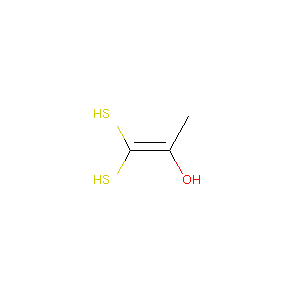

In [2]:

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.Draw import MolToImage, MolToFile, _moltoSVG, MolsToGridImage

smile1 = 'c1nnnc2c1nnn2'
smile7 = 'c1cnnc2n1ncc2'
smile6 = 'c1cncc2n1ccc2'
smile2='OC(=O)O'
smile3 ='c1cccc1'
smile4 = 'C(=C=Nc1c(c2c(OOI)cncn2)nc(Br)c2n1c(I)c(OO)c2)'
smile5 = 'C(OS(=O)(=O))C1SNC(c2c(I)c(NN=O)c(c3cc(F)ccc3C#C)cc2Cl)C(=Nc2nc(S(=O)(=O))c(c3nc(C(c4c(C#N)nnc5n4nnn5)F)nc4n3cnc4c3cnncc3N=C(S)c3c(F)cnc(I)n3)c3n2cnn3)N(SI)NC(F)O1'
smile8 = 'Oc1cc(O)oc1'
smile9 ='Clc1c(c2cnc([C@@][C@@]c3nnc([C@@H]CCS(=O)(=O))c4n3c(c3cnc()c5n3c([C@@]([C@@]([C@@][C@])))cn5)cn4)c3n2nnn3)nnc2n1nnn2'#'[O-]c1nc(O)cc1[C@@][C@]-c1cscc1'
smile9 = 'c5c(c6cnncc6)n(O)nn5'
smile10 ='C/C(O)=C(S)/S'
mol = Chem.MolFromSmiles(smile10)

MolToImage(mol, kekulize=False)

In [3]:
MolToFile(mol, 'test.svg', imageType='svg')

In [4]:
from generative_playground.models.model_settings import get_decoder, get_settings

max_len = 40
settings = get_settings(True, 'new')

# Now let's run a random model with a grammar
model, _ = get_decoder(True,
                    'new',
                    feature_len=settings['feature_len'],
                    max_seq_length=max_len,
                    decoder_type='random',
                   batch_size=9)



smiles -> valence_1 bond
smiles -> valence_2 double_bond
smiles -> valence_3 triple_bond
bond -> 'h'
bond -> nonH_bond
branch -> 'h'
branch -> '(' nonH_bond ')'
nonH_bond -> valence_1
nonH_bond -> valence_2 bond
nonH_bond -> valence_3 double_bond
nonH_bond -> valence_4 triple_bond
double_bond -> '=' valence_2
double_bond -> '=' valence_3 bond
double_bond -> '=' valence_4 double_bond
triple_bond -> '#' valence_3 
triple_bond -> '#' valence_4 bond
valence_4 -> 'C'
valence_4 -> '[' 'C' '@' ']'
valence_4 -> '[' 'C' '@' '@' ']'
valence_4 -> '[' 'N' '+' ']'
valence_3 -> '[' 'C' '@' 'H' ']'
valence_3 -> '[' 'C' '@' '@' 'H' ']'
valence_3 -> 'N'
valence_3 -> '[' 'N' 'H' '+' ']'
valence_3 -> valence_4 branch
valence_2 -> 'O'
valence_2 -> 'S'
valence_2 -> 'S' '(' '=' 'O' ')'  '(' '=' 'O' ')'
valence_2 -> valence_3 branch
valence_2 -> valence_4 '(' double_bond ')'
valence_1 -> 'F'
valence_1 -> 'Cl'
valence_1 -> 'Br'
valence_1 -> 'I'
valence_1 -> '[' 'O' '-' ']'
valence_1 -> '[' 'N' 'H' '3' '+' ']

['S(O/[C@@](c1c(C#[C@])c([C@@H]=N[C@@H](=S(=O)(=O)))c(S)c2n1ccc2)=[C@@H]/S)', '[N+](#[C@]S(=O)(=O)(c1cncc2n1nc([C@H]=[C@H])c2N[O-]))', 'Cl', '[C@H]([C@@]#[N+])=N', 'N(c1c([N+](=[C@H](O)))c([C@@](=[C@@]([C@H])([NH+]))Br)ns1)=O', '[C@](#N)-c1nnc([C@H]=[C@](S(=O)(=O))c2c([NH+]=S(=O)(=O))nnnc2)c(S(=O)(=O))n1', '[C@H]#C', 'I', 'I']
[2, 2, 0, 0, 1, 2, 0, 0, 0]


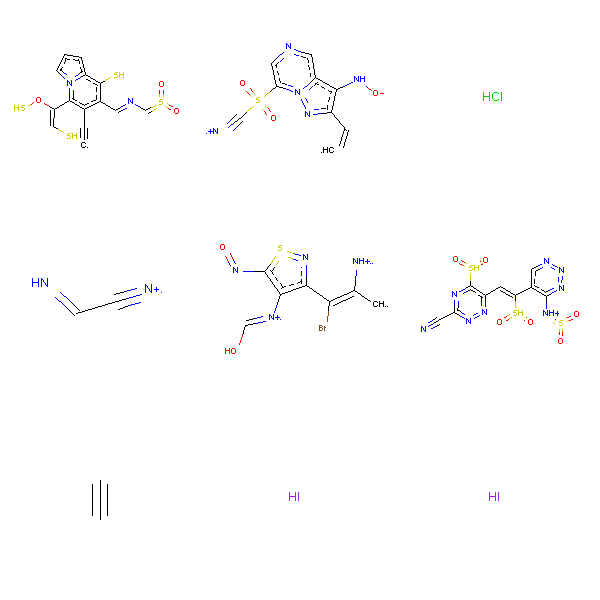

In [5]:
from generative_playground.codec.grammar_codec import GrammarModel
settings = get_settings(True, 'new')
codec = GrammarModel(grammar=settings['grammar'],
                    tokenizer=settings['tokenizer'])
actions = model()[0].detach().cpu().numpy()
#print(actions, settings['feature_len'])
my_smiles = codec.decode_from_actions(actions)
print(my_smiles)

mols = [Chem.MolFromSmiles(my_smile) for my_smile in my_smiles]
print([Descriptors.NumAromaticRings(m) for m in mols if m is not None])
MolsToGridImage(mols, kekulize=False)

In [6]:
#my_smiles.append'c1ccncn1']

def parse(x):
    # print(x)
    try:
        return next(codec._parser.parse(x))
    except Exception as e:
#         print('fail!')
#         print(e)
        return None
    
tokens = [codec._tokenize(s) for s in my_smiles]
parse_trees = [parse(t) for t in tokens]
print(parse_trees, len(parse_trees))


[Tree('smiles', [Tree('valence_1', [Tree('valence_2', ['S']), '(', Tree('nonH_bond', [Tree('valence_2', ['O']), Tree('slash', ['/']), Tree('valence_3', [Tree('valence_4', ['[', 'C', '@', '@', ']']), '(', Tree('nonH_bond', [Tree('double_aromatic_ring', ['c', Tree('num2', ['1']), Tree('aromatic_atom', ['c', '(', Tree('nonH_bond', [Tree('valence_4', ['C']), Tree('triple_bond', ['#', Tree('valence_4', ['[', 'C', '@', ']'])])]), ')']), Tree('aromatic_atom', ['c', '(', Tree('nonH_bond', [Tree('valence_3', ['[', 'C', '@', '@', 'H', ']']), Tree('double_bond', ['=', Tree('valence_3', ['N']), Tree('nonH_bond', [Tree('valence_1', [Tree('valence_3', ['[', 'C', '@', '@', 'H', ']']), '(', Tree('double_bond', ['=', Tree('valence_2', ['S', '(', '=', 'O', ')', '(', '=', 'O', ')'])]), ')'])])])]), ')']), Tree('aromatic_atom', ['c', '(', Tree('nonH_bond', [Tree('valence_1', [Tree('valence_2', ['S'])])]), ')']), 'c', Tree('num1', ['2']), 'n', Tree('num2', ['1']), Tree('aromatic_atom', ['c']), Tree('aromat

In [7]:
fname = '../data/250k_rndm_zinc_drugs_clean.smi'

with open(fname) as f:
    smiles = f.readlines()

for i in range(len(smiles)):
    smiles[i] = smiles[i].strip()


In [8]:
tokens = [codec._tokenize(s) for s in smiles[:1000]]
parse_trees = [parse(t) for t in tokens]
nice = [ip for ip, p in enumerate(parse_trees) if p is not None]
print(len(nice), nice)

359 [1, 2, 5, 6, 7, 16, 17, 26, 35, 36, 41, 43, 44, 48, 53, 55, 56, 57, 68, 71, 76, 77, 79, 80, 81, 89, 90, 93, 95, 99, 101, 104, 109, 110, 115, 116, 117, 118, 125, 126, 132, 133, 134, 137, 138, 139, 141, 144, 148, 149, 150, 151, 152, 154, 155, 156, 159, 160, 161, 163, 166, 171, 172, 177, 179, 182, 188, 189, 190, 193, 197, 199, 201, 204, 207, 209, 211, 216, 224, 225, 229, 236, 237, 239, 241, 244, 245, 246, 248, 249, 250, 251, 255, 256, 258, 264, 265, 268, 276, 278, 281, 283, 284, 285, 293, 295, 302, 307, 308, 310, 313, 315, 317, 322, 324, 326, 327, 332, 336, 337, 339, 347, 355, 358, 359, 361, 362, 364, 366, 372, 373, 380, 383, 392, 393, 395, 398, 399, 403, 407, 408, 410, 411, 414, 416, 417, 418, 419, 423, 428, 429, 430, 431, 432, 433, 436, 441, 444, 447, 448, 449, 451, 459, 464, 473, 475, 476, 479, 480, 483, 484, 489, 494, 497, 499, 500, 502, 503, 505, 511, 512, 514, 515, 516, 524, 529, 530, 531, 532, 533, 537, 540, 541, 543, 547, 548, 553, 558, 560, 562, 565, 570, 571, 572, 573, 576, 

In [13]:
i = 3

10 C[C@@H]1CN(O)CC[C@H]1[NH3+]
fail!


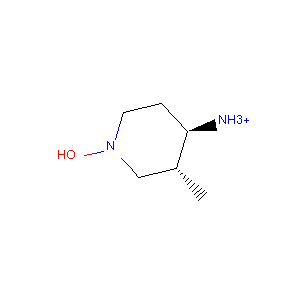

In [31]:
# C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
#N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)cc2)cc1
#C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
#smile = 'Nc2cncc(-c3nncn3C)c2'
smile =  smiles[i]
smile = 'C[C@@H]1CN(O)CC[C@H]1[NH3+]'
print(i, smile)
mol = Chem.MolFromSmiles(smile)
parse_tree = parse(codec._tokenize(smile))
if parse_tree is None:
    print('fail!')


MolToImage(mol, kekulize=False)


In [21]:
# i+=1
# my_smile =smiles[i]
# mols = [Chem.MolFromSmiles(my_smile)]
# print(i, my_smile, [Descriptors.NumAromaticRings(m) for m in mols])
# MolsToGridImage(mols, kekulize=False)


None


In [12]:

# from generative_playground.models import grammar_ed_models as grammar_model

# # We load the auto-encoder
# grammar_weights = '../pretrained/my_molecules.mdl'
# grammar_model = grammar_model.ZincGrammarModel(grammar_weights)
# z = grammar_model.encode(['c1nccc2n1ccc2'])
# new_smile = grammar_model.decode(z)